# Q1

In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        dos = ['apache2', 'back', 'land', 'neptune', 
               'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
        probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
        u2r = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
        r2l = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 
               'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 
               'warezmaster', 'xlock', 'xsnoop']
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 
                              (1.0 if name in dos else 
                               (2.0 if name in probe else 
                                (3.0 if name in u2r else 4.0))))
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    
    return pipeline 

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('../NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('../NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Creating the training, validation and test data sets
nslkdd_df_train = nslkdd_df 
nslkdd_df_validate,nslkdd_df_test = nslkdd_df_test.randomSplit([0.5,0.5])

nslkdd_df_train_pandas = nslkdd_df_train.withColumn('features', to_array('features')).toPandas()
nslkdd_df_validate_pandas = nslkdd_df_validate.withColumn('features', to_array('features')).toPandas()
nslkdd_df_test_pandas = nslkdd_df_test.withColumn('features', to_array('features')).toPandas()

22/11/17 22:45:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/11/17 22:45:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
# Converting the pandas DataFrame to tensors
# Note we are using 3 data sets train, validate, test
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

x_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['outcome'].values.tolist(),np.int64))

x_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['features'].values.tolist(),np.float32))
y_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['outcome'].values.tolist(),np.int64))

x_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['outcome'].values.tolist(),np.int64))


In [4]:
# Defining MyDataset Class
class MyDataset(Dataset): 
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx],self.y[idx])

# Turning the data from tensors to datasets
train_dataset = MyDataset(x_train,y_train)
validate_dataset = MyDataset(x_validate,y_validate)
test_dataset = MyDataset(x_test,y_test)



# Q2

In [5]:
# Create Neural Network
class myMultiLayerPerceptron(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential( 
            nn.Linear(input_dim,20),
            nn.ReLU(),
            nn.Linear(20,40),
            nn.ReLU(),
            nn.Linear(40,30),
            nn.ReLU(),
            nn.Linear(30,20),
            nn.ReLU(),
            nn.Linear(20,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    


In [6]:
mymodel = myMultiLayerPerceptron(x_train.shape[1],5) # creating a model instance

print(mymodel)

myMultiLayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=113, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=5, bias=True)
  )
)


# Q3-4

In [7]:
mymodel = myMultiLayerPerceptron(x_train.shape[1],5)

# Three hyper parameters for training
lr = .00005
batch_size = 48
N_epochs = 50

# Create loss function
loss_fun = nn.CrossEntropyLoss()

# Create dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset,batch_size = batch_size,shuffle = True)

# Create optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel


losses = [] # training losses of each epoch
accuracies = [] # training accuracies of each epoch

validate_losses = [] # validation losses of each epoch
validate_accuracies = [] # validation accuracies of each epoch

iteration_losses = []

current_best_accuracy = 0.0

for epoch in range(N_epochs):
    # Train loop
    batch_loss = [] # keep a list of losses for different batches in this epoch
    batch_accuracy = [] # keep a list of accuracies for different batches in this epoch
    for x_batch, y_batch in train_dataloader:
        # pass input data to get the prediction outputs by the current model
        prediction_score = mymodel(x_batch)

        # compute the cross entropy loss. Note that the first input to the loss_func should be the predicted scores (not probabilities), and the second input should be class labels as integers
        loss = loss_fun(prediction_score,y_batch)

        # compute the gradient
        optimizer.zero_grad()
        loss.backward()

        # update parameters with optimizer step
        optimizer.step()

        # append the loss of this batch to the batch_loss list
        batch_loss.append(loss.detach().numpy())
        

        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 
    
    
    # Validation loop
    validate_batch_loss = [] # keep a list of losses for different validate batches in this epoch
    validate_batch_accuracy = [] # same for the accuracy
    for x_batch, y_batch in validate_dataloader:
        # pass input data to get the prediction outputs by the current model
        prediction_score = mymodel(x_batch)

        # compare prediction and the actual output and compute the loss
        loss = loss_fun(prediction_score,y_batch)

        # append the loss of this batch to the validate_batch_loss list
        validate_batch_loss.append(loss.detach())


        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 
    
    # save the loss for each iteration
    iteration_losses.append(batch_loss)
    
    # calculate the average train loss and validate loss in this epoch and record them
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append( np.mean(np.array(validate_batch_loss)))

    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))

    # Printing
    print(f"Epoch = {epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train accuracy = {np.round(accuracies[-1]*100,2)}%, validate accuracy = {np.round(validate_accuracies[-1]*100,2)}% ")
    
    # If the validate metric of this epoch is the best so far, save the model
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is the best so far. Saving model...") 
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]



Epoch = 0,train_loss=0.6500818729400635,validate_loss=1.1561527252197266
Train accuracy = 80.83%, validate accuracy = 66.46% 
Current epoch is the best so far. Saving model...
Epoch = 1,train_loss=0.17187313735485077,validate_loss=1.2233997583389282
Train accuracy = 95.12%, validate accuracy = 71.15% 
Current epoch is the best so far. Saving model...
Epoch = 2,train_loss=0.1049734503030777,validate_loss=1.2779207229614258
Train accuracy = 97.3%, validate accuracy = 73.36% 
Current epoch is the best so far. Saving model...
Epoch = 3,train_loss=0.0907902866601944,validate_loss=1.3663668632507324
Train accuracy = 97.62%, validate accuracy = 73.84% 
Current epoch is the best so far. Saving model...
Epoch = 4,train_loss=0.08109491318464279,validate_loss=1.443023681640625
Train accuracy = 97.71%, validate accuracy = 73.96% 
Current epoch is the best so far. Saving model...
Epoch = 5,train_loss=0.07237592339515686,validate_loss=1.478283166885376
Train accuracy = 97.72%, validate accuracy = 74

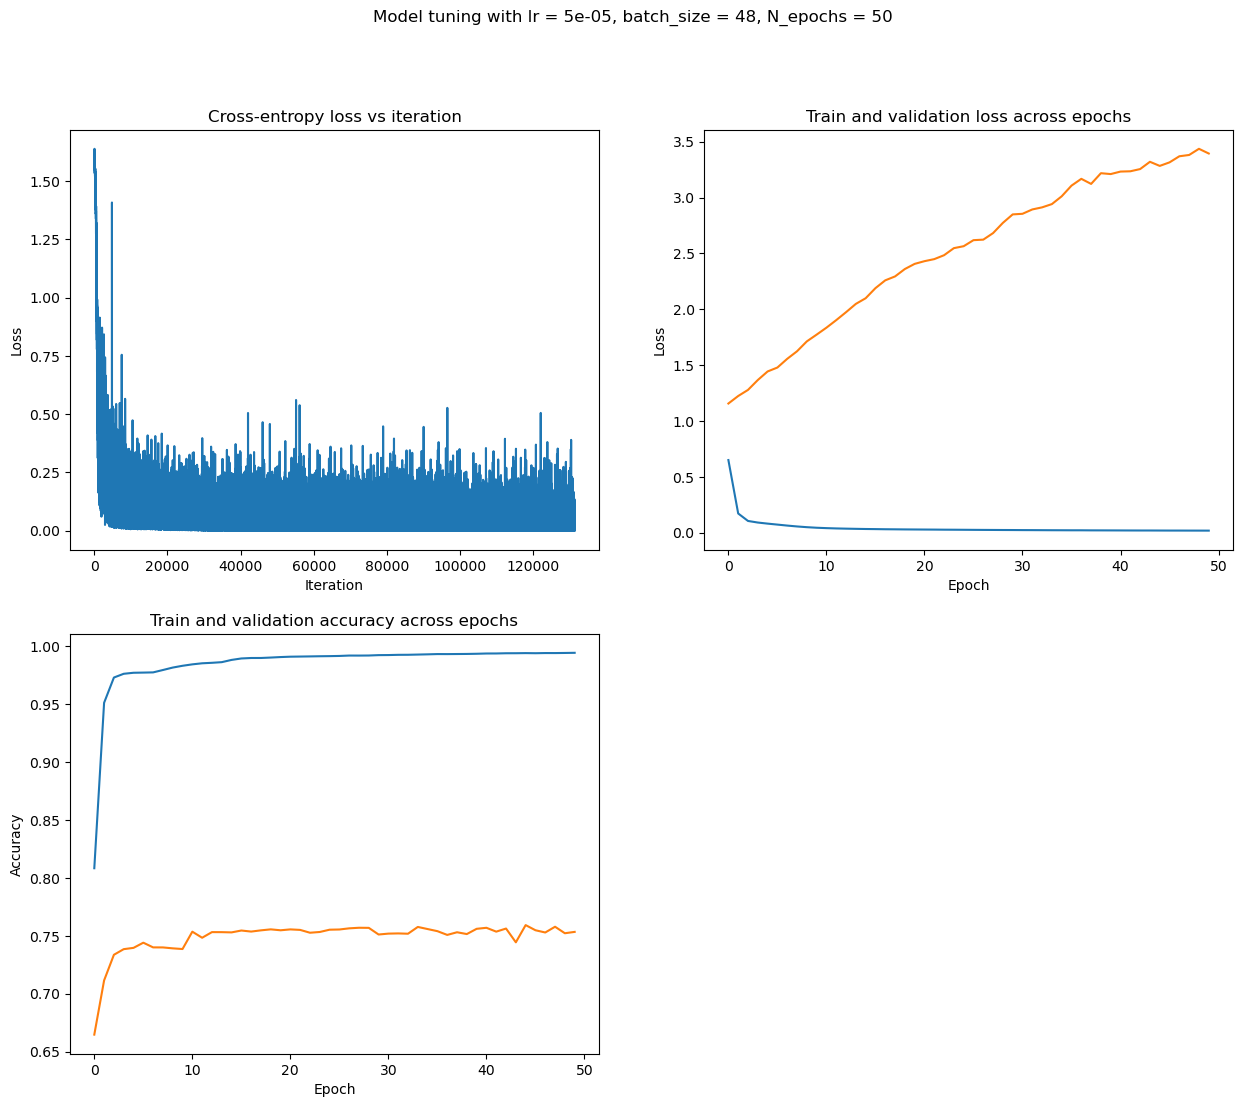

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=[15,12])
fig.suptitle(f"Model tuning with lr = {lr}, batch_size = {batch_size}, N_epochs = {N_epochs}")
axs[0, 0].plot(np.ravel(iteration_losses))
axs[0, 0].set_title("Cross-entropy loss vs iteration")
axs[0, 0].set(xlabel='Iteration', ylabel='Loss')

axs[0, 1].plot(losses, label="Train Loss")
axs[0, 1].plot(validate_losses, label="Validation Loss")
axs[0, 1].set_title("Train and validation loss across epochs")
axs[0, 1].set(xlabel='Epoch', ylabel='Loss')


axs[1, 0].plot(accuracies, label="Train Accuracy")
axs[1, 0].plot(validate_accuracies, label="Validation Accuracy")
axs[1, 0].set_title("Train and validation accuracy across epochs")
axs[1, 0].set(xlabel='Epoch', ylabel='Accuracy')

axs[1, 1].set_axis_off()
plt.show()

I started with hyper-parameter values similar to what was used in the lectures, and saw that the loss (I especially focused on loss per iterations at first) had some spikes and was very noisy throughout, so I decided to try lowering the learning rate, increasing epochs so that the model can converge.
I kept lowering learning rate and increasing epochs until I saw a loss that seem to converge well without too much noise, especially during later epochs. I ended up with learning rate ot 5e-5, batch size of 64 and 100 epochs, but I noticed that the loss converged around 40-50 epochs. After this I tried lowering the number of epochs and also decided to try to play with the batch size, lowering it to 48 but there wasn't much change.

# Q5

In [9]:
# create a new model with the same input-output dimension as before
mybestmodel = myMultiLayerPerceptron(x_train.shape[1],5)

# load the "state_dict" from file into the new model
mybestmodel.load_state_dict(torch.load("current_best_model"))

# conduct testing via a test loop
test_dataloader = DataLoader(test_dataset,batch_size = batch_size,shuffle = True)
test_batch_accuracy = []
for x_batch, y_batch in test_dataloader:
    # pass input data to get the prediction outputs 
    prediction_score = mybestmodel(x_batch)

    # Compute metrics for this batch here
    prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
    test_batch_accuracy.append( np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0]) 

# compute the mean accuracy across all batches
test_accuracy = np.mean(np.array(validate_batch_accuracy))

print(f"Test accuracy = {np.round(test_accuracy*100,2)}%")

Test accuracy = 75.34%
